In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import s3fs
import scipy.stats
import time
import multiprocessing as mp
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import ast
import glob
import json
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import torch
import torch.nn as nn

# Utils for  reading data

In [40]:
def collect_featured_data_from_s3(path, fs):
    top_dir = fs.ls(path)
    data = []
    
    for files in top_dir:
        df = None
        bottom_dir = fs.ls(files)
        df = combine_multiple_json(bottom_dir)
        #df = get_acceleration_timeseries(df)
        #params = [df, 'unkown', np.arange(0,100,10)]
        #example = featurize(params)
        data.append(df)
        
    return data # a list that has a featurized vector (dictioanry) for each folder in top_dir (each capture session)
    
def mp_collect_featured_data_from_s3(path, fs):
    top_dir = fs.ls(path)
    data = []
    data_params = []
    
    for files in top_dir:
        df = None
        bottom_dir = fs.ls(files)
        df = combine_multiple_json(bottom_dir)
        df = get_accleration_timeseries(df)
        params = (df, 'unkown', np.arange(0,100,10))
        data_params.append(params)
        
    then = time.time()
    pool = mp.Pool(processes=8)
    data = pool.map(featurize,data_params)
    print((time.time()-then)/60, "minutes")
        
    return data # a list that has a featurized vector (dictioanry) for each folder in top_dir (each capture session)

def combine_multiple_json(bottom_dir):
    '''bottom_dir -> json files for one sample
    '''
    
    dict_list = [] #one element per timestamp for sample
    
    for partial_json  in bottom_dir: #loop over json files (one per minute)
        with fs.open(partial_json) as f:
            temp_json = json.loads(f.read())
            
            if 'motion' in temp_json: #temp_json['motion'] is a list of dicts
                temp_data = process_motion_dict(temp_json['motion'])
                dict_list += temp_data
    
    data = pd.DataFrame(dict_list)
    if data.shape[0] > 0:
        data.sort_values('timestamp', ascending=True, inplace=True)
    
    return data

def process_motion_dict(dict_list):
    '''
    helper function for combine_multiple_json
    flatten dictionaries in dict_list
    return value: list of 1-level dicts
    '''

    keys_to_keep = ['acceleration', 'rotationRate']
    
    result_list = []
    for element in dict_list:
        result = {}
        result['timestamp'] = element['timestamp']
        for k in keys_to_keep:
            if k in element:
                for l in element[k]:
                    result[f'{k}_{l}'] = element[k][l]
        
        result_list.append(result)
    
    return result_list
    
def get_acceleration_timeseries(timeseries):    
    timeseries = timeseries[['acceleration_x', 'acceleration_y', 'acceleration_z']]
    
    timeseries = timeseries.apply((lambda x: x**2))
    timeseries = timeseries.sum(axis=1)
    timeseries = timeseries.apply(np.sqrt)
    
    return timeseries # 1xn Series 

def get_position_velocity(acc):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of displacement and speed time-series
    '''
    
    delta_time = 1 #time-step

    pos, vel = np.zeros_like(acc), np.zeros_like(acc)
    
    for t in range(1, acc.shape[0]):
        vel[t] = vel[t-1] + acc[t-1] * delta_time
                
        pos[t] = pos[t-1] + vel[t-1]*delta_time + (1./2)*acc[t-1]*(delta_time**2)
            
    return pos, vel

def featurize(params):
    ts = params[0]
    label = params[1]
    bins = params[2]
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    features['label'] = label
    
    
    return features
    


In [41]:
fs = s3fs.S3FileSystem(key=os.environ['AWSACCESSKEYID'], secret=os.environ['AWSSECRETACCESSKEY'])

path_to_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-26'
data26 = collect_featured_data_from_s3(path_to_data, fs)

path_to_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-27'
data27 = collect_featured_data_from_s3(path_to_data, fs)

In [42]:
print(len(data26))
print(len(data27))

185
272


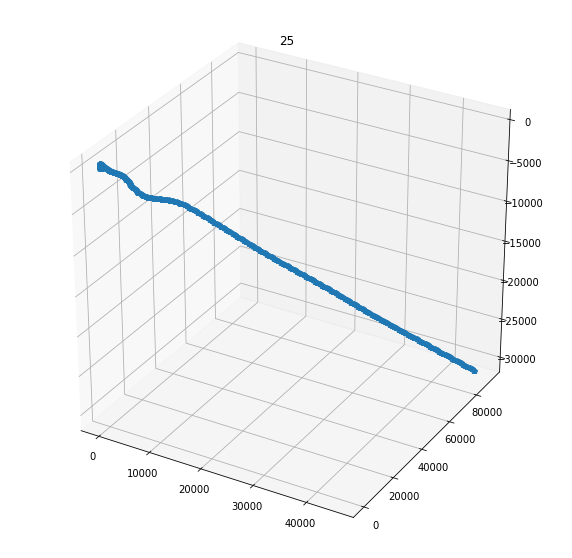

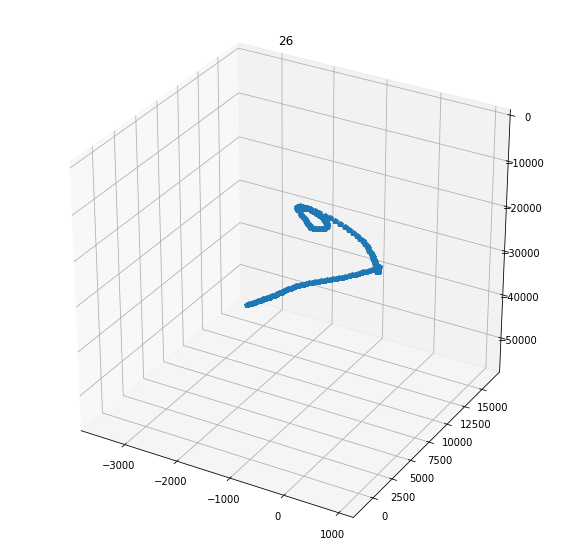

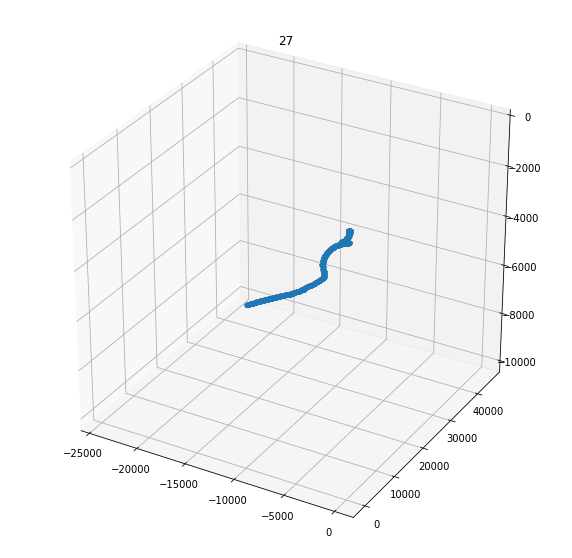

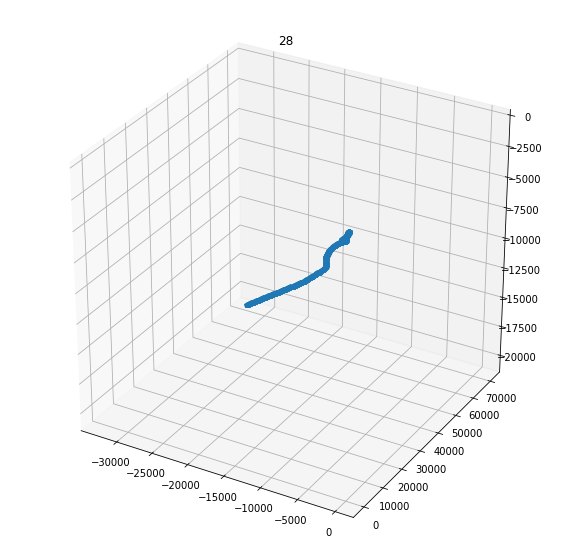

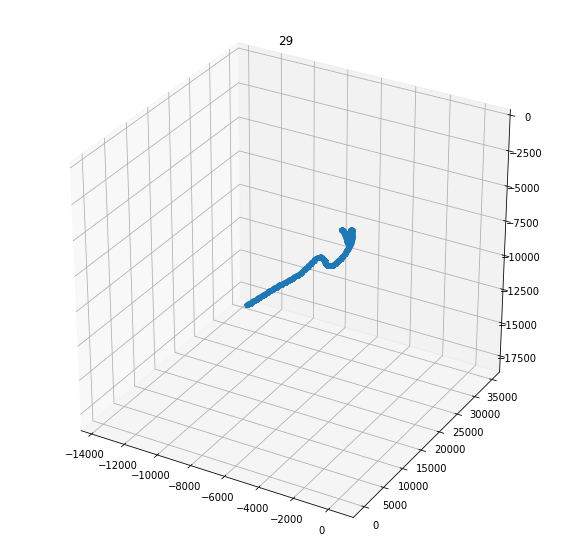

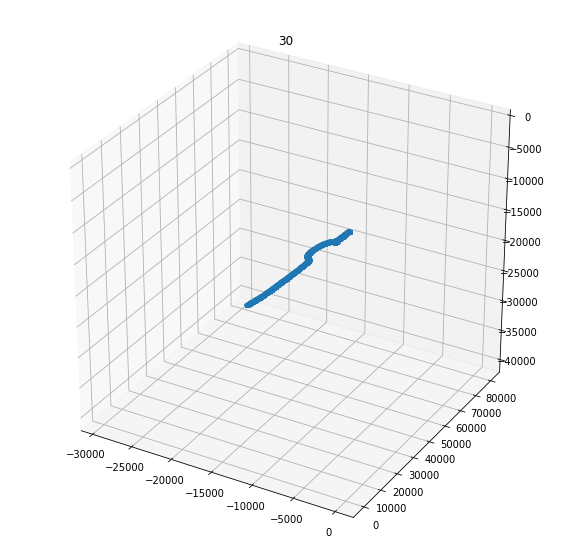

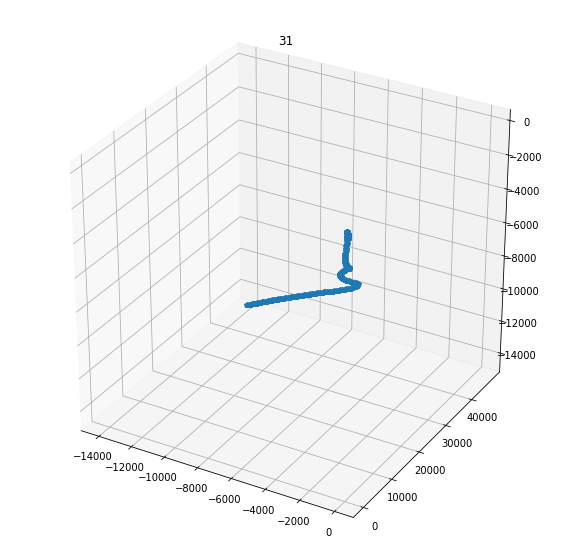

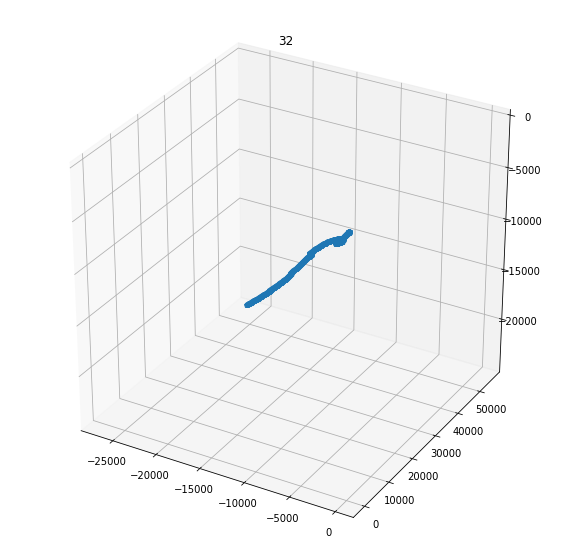

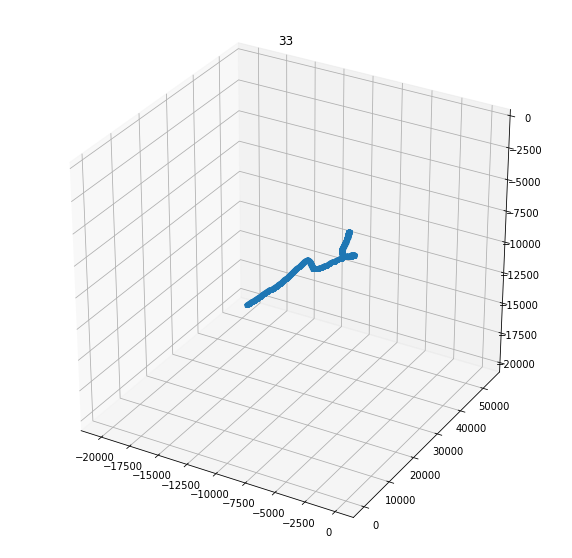

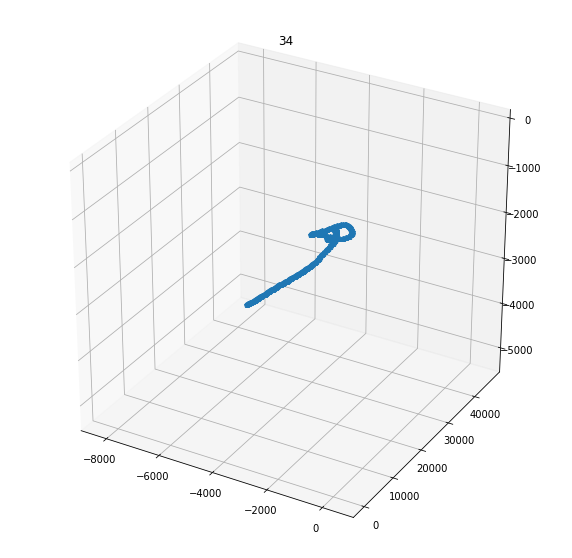

In [43]:
plot_pca = False
data = data26
for index in range(25,35):
    if data[index].shape[0] == 0:
        continue
    
    pos_x, vel_x = get_position_velocity(data[index]['acceleration_x'])
    pos_y, vel_y = get_position_velocity(data[index]['acceleration_y'])
    pos_z, vel_z = get_position_velocity(data[index]['acceleration_z'])

    if not plot_pca:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(pos_x, pos_y, pos_z, 'p')
        plt.title(index)
    else:
        fig = plt.figure(figsize=(10,10))
        
        pos_df = pd.DataFrame({'x': pos_x, 'y': pos_y, 'z': pos_z})
        pos_df = (pos_df - pos_df.mean(axis=0)) / pos_df.std(axis=0)

        model = PCA(n_components=2)

        pos_pca_df = model.fit_transform(pos_df)
        plt.plot(pos_pca_df[:,0], pos_pca_df[:,1])        

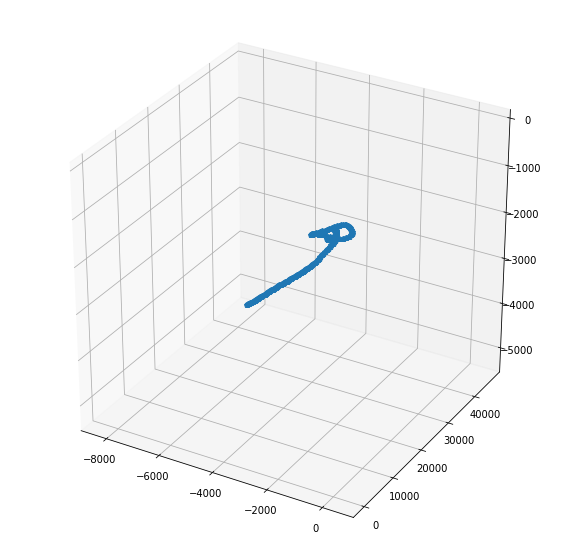

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_x, pos_y, pos_z, 'p')

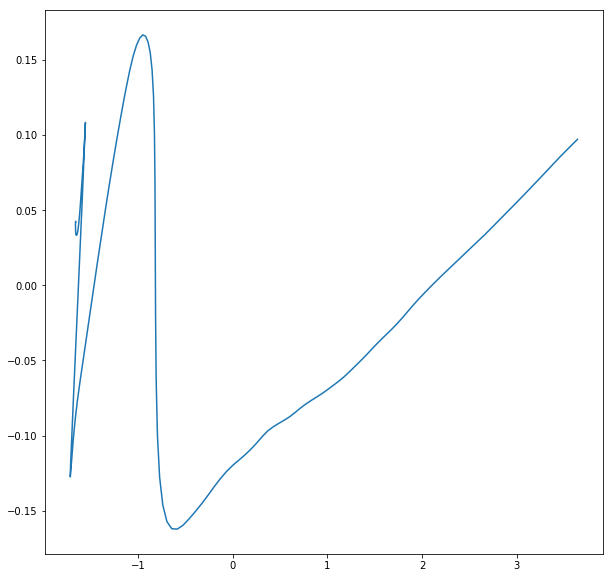

In [45]:
pos_df = pd.DataFrame({'x': pos_x, 'y': pos_y, 'z': pos_z})
pos_df = (pos_df - pos_df.mean(axis=0)) / pos_df.std(axis=0)

model = PCA(n_components=2)

pos_pca_df = model.fit_transform(pos_df)

fig = plt.figure(figsize=(10,10))
plt.plot(pos_pca_df[:,0], pos_pca_df[:,1])

## Exploratory

In [39]:
data[0]

,acceleration_x,acceleration_y,acceleration_z,timestamp
0,-1.445350,-7.160908,-5.489755,1551190778880
1,-1.305438,-6.763769,-5.948094,1551190778897
2,-1.199794,-6.813748,-6.471228,1551190778913
3,-1.009156,-6.552331,-7.506570,1551190778930
4,-1.131260,-6.311714,-7.929446,1551190778946
5,-0.924012,-6.515072,-7.840262,1551190778963
6,-0.997784,-6.570737,-7.171233,1551190778980
7,-1.309778,-6.614132,-7.449259,1551190778997
8,-1.435474,-6.585252,-7.680300,1551190779013
9,-0.989254,-6.570288,-7.707234,1551190779030
